# Training a classifier

pytorch를 사용하기 위해서는 data를 tensor로 변경하는 작업이 필요

- image : Pillow, openCV
- audio : scipy, librosa
- text : raw data, nltk, spacy


-> image는 `torchvision` 이용

### torchvision
- 'torchvision.datasets' : Imagenet, CIFAR10, MNIST
- 'torch.utils.data.DataLoader'

### Train image classifier
1. Load the data
2. CNN 정의
3. loss 정의
4. train
5. test

#### 1. Load the data

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

- input data :  [-1, 1]로 normalize Tensor를 변환
- output data : [0, 1]에서 Image

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# train data
trainset = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 4, shuffle = True, num_workers = 2)

# test data
testset = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = 4, shuffle = False, num_workers = 2)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

#### Load CIFAR10

In [7]:
import matplotlib.pyplot as plt
import numpy as np

In [11]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [12]:
# iter로 변환
dataiter = iter(trainloader)
images, labels = dataiter.next()

horse   dog horse truck


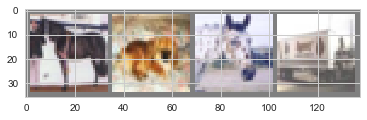

In [14]:
# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

#### 2. Define CNN

In [16]:
import torch.nn as nn
import torch.nn.functional as F

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = x.view(-1, 16*5*5)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [18]:
net = Net()

#### 3. Define Loss function, optimizer

In [19]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

#### 4. Train network

In [21]:
for epoch in range(2):
    
    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        
        # get data
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.181
[1,  4000] loss: 1.804
[1,  6000] loss: 1.687
[1,  8000] loss: 1.562
[1, 10000] loss: 1.526
[1, 12000] loss: 1.473
[2,  2000] loss: 1.405
[2,  4000] loss: 1.386
[2,  6000] loss: 1.350
[2,  8000] loss: 1.323
[2, 10000] loss: 1.305
[2, 12000] loss: 1.281
Finished Training


#### 5. Test network

GroundTruth:    cat  ship  ship plane


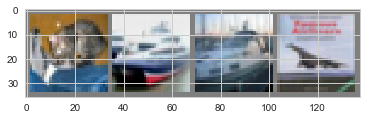

In [22]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [23]:
outputs = net(images)

In [26]:
_, predicted = torch.max(outputs, 1)
print('printed : ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

printed :    cat  ship   car  ship


In [29]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images : %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images : 55 %


In [38]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 61 %
Accuracy of   car : 79 %
Accuracy of  bird : 24 %
Accuracy of   cat : 47 %
Accuracy of  deer : 42 %
Accuracy of   dog : 34 %
Accuracy of  frog : 75 %
Accuracy of horse : 72 %
Accuracy of  ship : 65 %
Accuracy of truck : 54 %


#### 6. Train on GPU

In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


- .to(device, dtype)


- net과 input을 cuda로 변경

In [40]:
net.to(device)

C:\Users\magenta_jy\Anaconda3\lib\site-packages\torch\cuda\__init__.py:116: UserWarning: 
    Found GPU0 GeForce 710M which is of cuda capability 2.1.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [41]:
inputs, labels = inputs.to(device), labels.to(device)